In [36]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [37]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout

In [52]:
BASE_DIR = "../../../raw_data/brisc2025/segmentation_task/test"
BASE_DIR_ABSOLU = os.path.abspath(BASE_DIR)

BRISC_IMAGES_DIR = os.path.join(BASE_DIR, "images")
BRISC_MASKS_DIR = os.path.join(BASE_DIR, "masks")
MODEL_PATH = "/Users/victor/code/u-net_final_best.h5"
IMG_SIZE = 256

In [45]:
# --- 1. DÉFINITION DES MÉTRIQUES (DICE) ---
def dice_coef(y_true, y_pred):
    # On aplatit les images pour comparer pixel par pixel
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    # Formule du Dice : (2 * Intersection) / (Total pixels prédits + Total pixels réels)
    # Le smooth=1 évite la division par zéro
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [34]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # --- ENCODEUR (La Descente) ---
    # On garde 4 niveaux pour la complexité, mais on contrôle les filtres.

    # Niveau 1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Niveau 2
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Niveau 3
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Niveau 4
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # --- BOTTLENECK OPTIMISÉ ---
    # Au lieu de 256, on met 160. C'est le secret pour rester autour de 1M.
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # --- DÉCODEUR (La Remontée) ---

    # Remontée Niveau 4
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Remontée Niveau 3
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Remontée Niveau 2
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # Remontée Niveau 1
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Sortie (Masque binaire)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

print("✅ Modèle Optimisé (~1M params) défini !")
model = simple_unet_model(IMG_SIZE, IMG_SIZE, 3)
model.summary()

✅ Modèle Optimisé (~1M params) défini !
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                     

In [ ]:
try:
    # 1. On construit l'architecture vide
    # (Cela crée le squelette du modèle compatible avec ta version locale de Keras)
    print("Construction de l'architecture modèle...")
    model = simple_unet_model(IMG_SIZE, IMG_SIZE, 3)

    # 2. On injecte les poids
    # (On ignore la config de sauvegarde qui posait problème et on ne prend que les chiffres)
    print(f"Chargement des poids depuis {MODEL_PATH}...")
    model.load_weights(MODEL_PATH)

    print("✅ Modèle chargé avec succès (Poids injectés) !")

except Exception as e:
    print(f"❌ Erreur : {e}")

Construction de l'architecture modèle...
Chargement des poids depuis /Users/victor/code/u-net_final_best.h5...
✅ Modèle chargé avec succès (Poids injectés) !


In [ ]:
def preprocess_brisc_data(img_path, mask_path, img_size=256):
    # 1. Image
    img = cv2.imread(img_path)
    if img is None: return None, None, None

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l2 = clahe.apply(l)
    img = cv2.cvtColor(cv2.merge((l2, a, b)), cv2.COLOR_LAB2BGR)

    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img_tensor = np.expand_dims(img, axis=0)

    # 2. Masque (CORRECTION ICI)
    # D'abord on LIT le fichier
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # On vérifie que la lecture a marché
    if mask is None:
        return None, None, None

    # Ensuite on REDIMENSIONNE l'image lue
    mask = cv2.resize(mask, (img_size, img_size))

    mask = mask / 255.0
    mask = (mask > 0.5).astype(np.float32)

    return img_tensor, mask, img

In [ ]:
try:
    model = load_model(MODEL_PATH, custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})
    print("✅ Modèle chargé avec succès (Métriques corrigées).")
except Exception as e:
    print(f"❌ Erreur chargement modèle : {e}")
    raise


🔍 Analyse de 5 images BRISC (Conversion JPG -> PNG)...


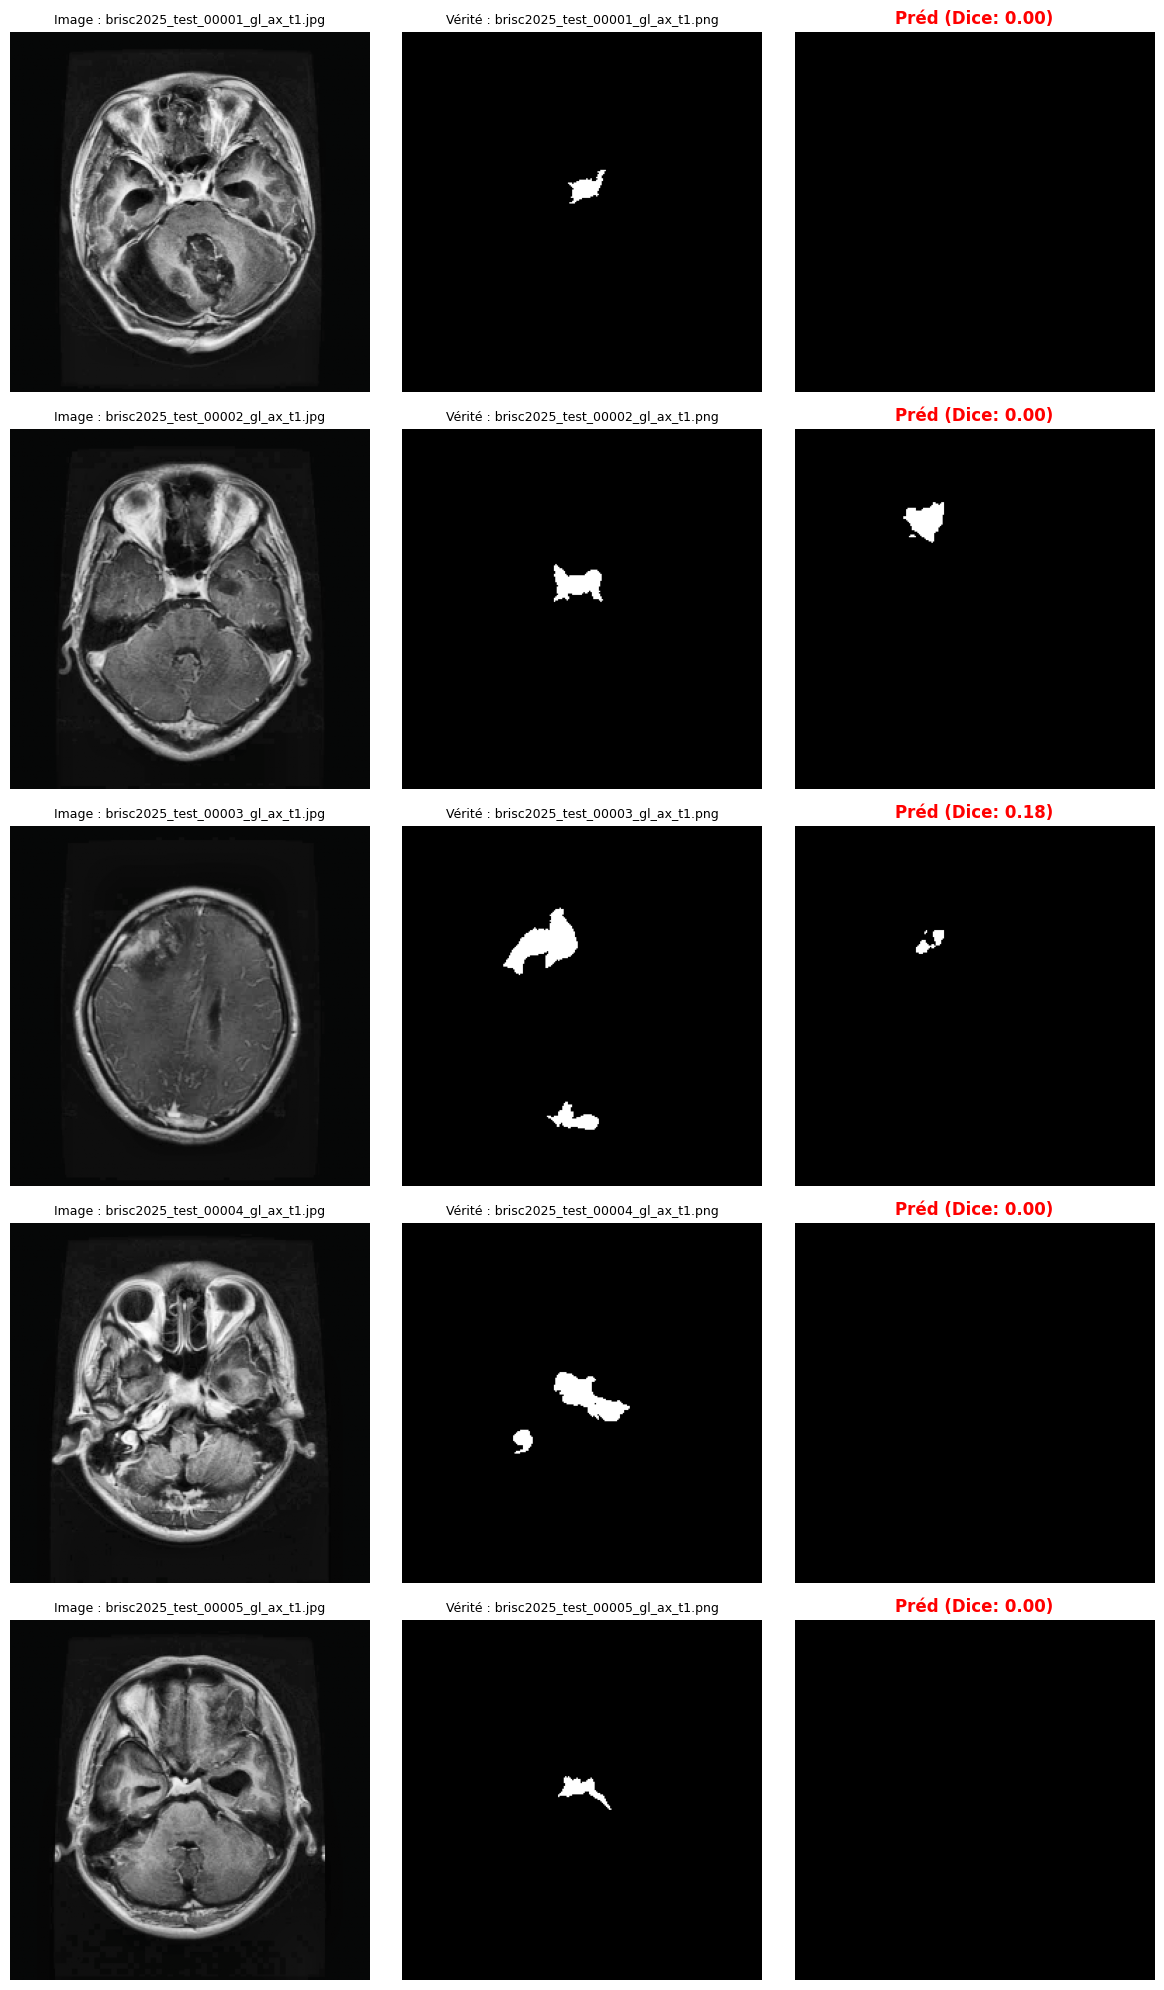

In [51]:
# 2. Récupération des fichiers
extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif']
image_files = []
for ext in extensions:
    image_files.extend(glob(os.path.join(BRISC_IMAGES_DIR, ext)))

# On prend les 5 premiers pour tester
image_files = sorted(image_files)[:5]

if not image_files:
    print(f"⚠️ Aucune image trouvée dans {BRISC_IMAGES_DIR}")
    print(f"Chemin testé : {os.path.abspath(BRISC_IMAGES_DIR)}")
else:
    print(f"🔍 Analyse de {len(image_files)} images BRISC (Conversion JPG -> PNG)...")

    plt.figure(figsize=(12, 4 * len(image_files)))

    for i, img_file in enumerate(image_files):
        filename = os.path.basename(img_file)     # ex: brisc_test_01.jpg
        name_no_ext = os.path.splitext(filename)[0] # ex: brisc_test_01

        # --- LOGIQUE CORRIGÉE : Changement d'extension ---
        # On remplace l'extension '.jpg' par '.png' dans le dossier masks
        mask_filename_png = name_no_ext + ".png"
        mask_file = os.path.join(BRISC_MASKS_DIR, mask_filename_png)

        if not os.path.exists(mask_file):
            print(f"⚠️ Masque introuvable pour {filename} (Cherché : {mask_filename_png})")
            continue

        # --- SUITE NORMALE (Prétraitement & Prédiction) ---
        img_tensor, true_mask, img_display = preprocess_brisc_data(img_file, mask_file, IMG_SIZE)

        if img_tensor is not None:
            pred = model.predict(img_tensor, verbose=0)
            pred_mask = (pred[0] > 0.5).astype(np.float32).squeeze()

            # Dice (Calcul de performance sur cette image)
            intersection = np.sum(true_mask * pred_mask)
            dice = (2. * intersection + 1) / (np.sum(true_mask) + np.sum(pred_mask) + 1)

            # Affichage
            plt.subplot(len(image_files), 3, i*3 + 1)
            plt.imshow(img_display[..., ::-1])
            plt.title(f"Image : {filename}", fontsize=9)
            plt.axis('off')

            plt.subplot(len(image_files), 3, i*3 + 2)
            plt.imshow(true_mask, cmap='gray')
            plt.title(f"Vérité : {os.path.basename(mask_file)}", fontsize=9)
            plt.axis('off')

            plt.subplot(len(image_files), 3, i*3 + 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title(f"Préd (Dice: {dice:.2f})", color='green' if dice > 0.6 else 'red', fontweight='bold')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# --- 4. EXÉCUTION DE L'ÉVALUATION ---

# A. Chargement Modèle
print("⚙️ Chargement du modèle...")
try:
    # On suppose que 'simple_unet_model' est bien défini dans ta session
    model = simple_unet_model(IMG_SIZE, IMG_SIZE, 3)
    model.load_weights(MODEL_PATH)
    print("✅ Modèle chargé.")
except Exception as e:
    print(f"❌ Erreur modèle : {e}")
    # Arrêt d'urgence
    raise

# B. Récupération des fichiers
image_files = sorted(glob(os.path.join(BRISC_IMAGES_DIR, "*.jpg")))
print(f"📊 Nombre d'images à tester : {len(image_files)}")

dice_scores = []

print("🚀 Démarrage du test complet...")

for i, img_file in enumerate(image_files):
    filename = os.path.basename(img_file)
    name_no_ext = os.path.splitext(filename)[0]

    # Recherche du masque (Extension .png)
    mask_file = os.path.join(BRISC_MASKS_DIR, name_no_ext + ".png")

    if not os.path.exists(mask_file):
        # On ignore silencieusement ou on log, selon ton choix.
        # Pour une moyenne juste, mieux vaut ignorer les fichiers sans masque.
        continue

    # Prétraitement
    img_tensor, true_mask, _ = preprocess_brisc_data(img_file, mask_file, IMG_SIZE)

    if img_tensor is not None:
        # Prédiction
        pred = model.predict(img_tensor, verbose=0)
        pred_mask = (pred[0] > 0.5).astype(np.float32).squeeze()

        # Calcul Dice individuel (Formule smooth=1)
        intersection = np.sum(true_mask * pred_mask)
        dice = (2. * intersection + 1) / (np.sum(true_mask) + np.sum(pred_mask) + 1)

        dice_scores.append(dice)

    # Petit indicateur de progression tous les 10 fichiers
    if (i + 1) % 10 == 0:
        print(f"   Processed {i + 1}/{len(image_files)} - Current Mean Dice: {np.mean(dice_scores):.4f}", end='\r')

# --- 5. RÉSULTATS FINAUX ---
final_mean_dice = np.mean(dice_scores)
print(f"\n\n🏆 RÉSULTATS SUR BRISC ({len(dice_scores)} images évaluées) :")
print(f"   Moyenne Dice Score : {final_mean_dice:.4f}")

if final_mean_dice > 0.65:
    print("✅ Conclusion : Le modèle généralise bien sur ce nouveau dataset !")
elif final_mean_dice > 0.50:
    print("⚠️ Conclusion : Performance moyenne, peut nécessiter un finetuning.")
else:
    print("❌ Conclusion : Échec de la généralisation (Domaine trop différent).")

⚙️ Chargement du modèle...
✅ Modèle chargé.
📊 Nombre d'images à tester : 860
🚀 Démarrage du test complet...
   Processed 860/860 - Current Mean Dice: 0.1883

🏆 RÉSULTATS SUR BRISC (860 images évaluées) :
   Moyenne Dice Score : 0.1883
❌ Conclusion : Échec de la généralisation (Domaine trop différent).
